In [1]:
import seaborn as sbn
import os
import cooler
import matplotlib.pyplot as plt
import numpy as np
import cooltools
import matplotlib.colors as cl
import pandas as pd
import warnings
import bbi
import matplotlib.patches as patches
from NGS import HiCTools as HT
import matplotlib
from typing import Callable

# Define functions

In [2]:
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = False) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

# Define pdf fonttype

In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42

# Set Wd

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/")

# Precalculate genome wide pairing score for mean normalization
Genome wide contact density is precalculated for matrix with bin size 20 kb. 200kb windowsize.

In [5]:
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
genomeWidePairingScore = getPairingScore(clrs["trans"], windowsize=20*10**4, norm=False, blankDiag=True)["PairingScore"]

# Define colormap

In [6]:
cmapFall = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)

# Chromosome 1 long arm (Fig. 2a)

## Extract Hi-C matrix

In [7]:
BINSIZE = 500000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

In [8]:
coord = "chr1:160000000-249000000"

In [9]:
allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

## Plot example

/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


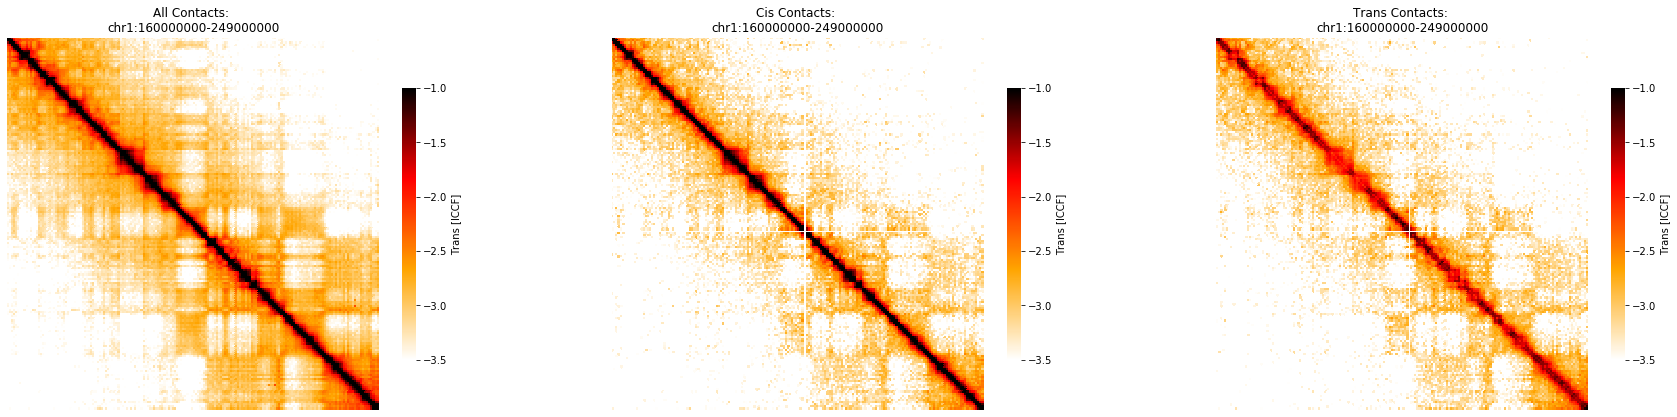

In [10]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## Write to file

In [12]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr1_long_arm_500kb.pdf"), bbox_inches="tight")

# Plot example on chromosome 8 (Fig. 2e)

In [11]:
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr8:95500000-99500000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/anaconda3/envs/ngs_base/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


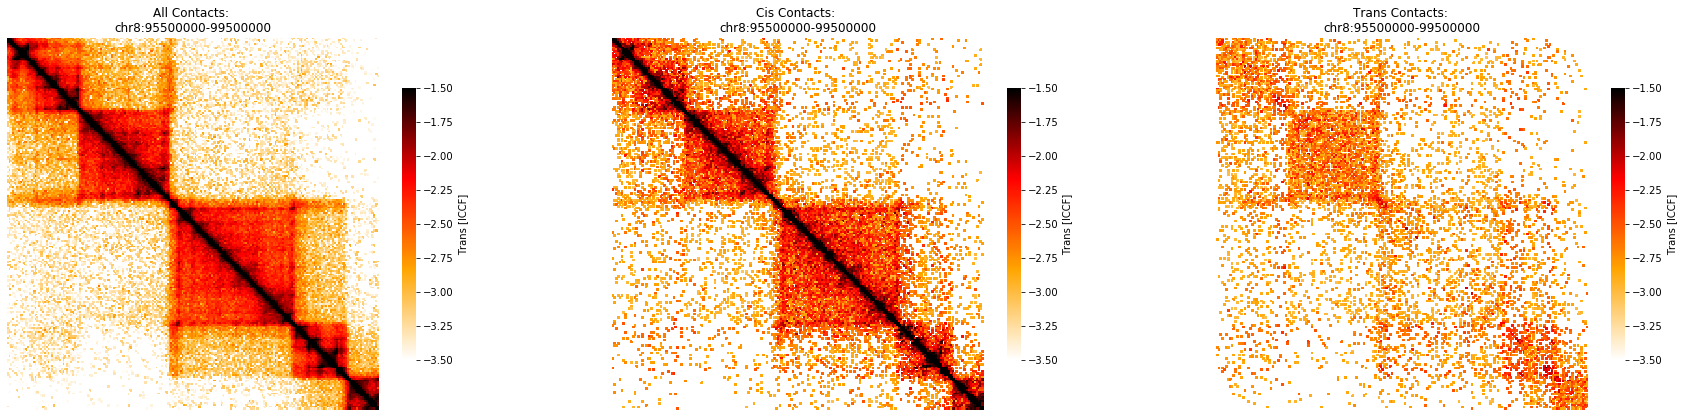

In [12]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

### Write to file

In [28]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb.pdf"), bbox_inches="tight")

## Calculate cis/trans ratio - obs/exp

In [17]:
arms = HT.getArmsHg19()

In [18]:
exp = {interType:
       HT.getExpected(clrs[interType], arms, proc=10)
       for interType in ["cis", "trans"]
       }

In [19]:
transSnipper = cooltools.snipping.ObsExpSnipper(clrs["trans"], exp["trans"])
cisSnipper = cooltools.snipping.ObsExpSnipper(clrs["cis"], exp["cis"])

In [20]:
region = pd.DataFrame({"chrom": coord.split(":")[0],
                       "start": int(coord.split(":")[1].split("-")[0]),
                       "end": int(coord.split(":")[1].split("-")[1]),
                       "region": "chr8:45600000-146364022"}, index=[0])
region

chrom     start       end                   region
0  chr8  95500000  99500000  chr8:45600000-146364022

In [21]:
transExamp = cooltools.snipping.pileup(region, transSnipper.select, transSnipper.snip)
cisExamp = cooltools.snipping.pileup(region, cisSnipper.select, cisSnipper.snip)

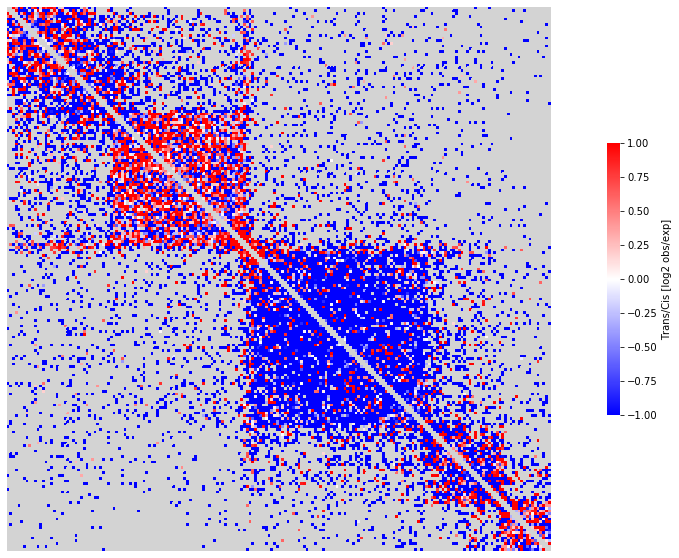

In [22]:
# ratio
ratio = transExamp[:,:, 0]/cisExamp[:, :, 0]
# add pseudocount
ratio = ratio + 0.01
#calcualte ratio
transOcis = np.log2(ratio)
# define colormap
cmap = plt.cm.bwr
cmap.set_bad("lightgrey")
#plot
f, ax = plt.subplots()
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(transOcis, cmap=cmap, ax=ax, vmin=-1, vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans/Cis [log2 obs/exp]"})
f.set_size_inches(20, 10)
plt.show()

### Write to file

In [23]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb_obs_exp_ratio.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb_obs_exp_ratio.pdf"), bbox_inches="tight")

## Plot pairing score with TAD-locations as xticklabels

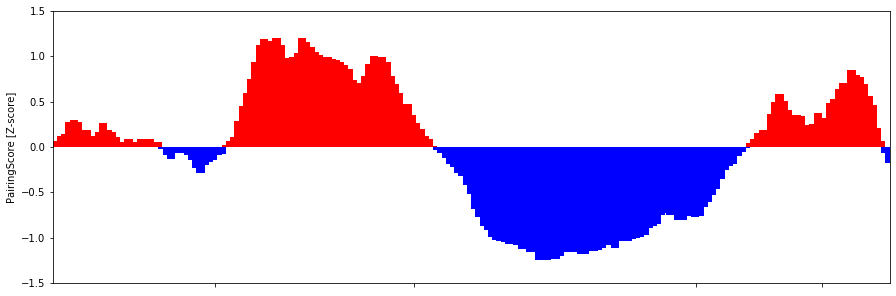

In [15]:
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=20*10**4, norm=False, blankDiag=True)["PairingScore"]
# normalize 
pairingScoreTrans = (pairingScoreTrans - np.nanmedian(genomeWidePairingScore))/np.nanstd(genomeWidePairingScore)
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])

# split positive and negative values to be able to plot them in different colors; 0 values are not plotted
pos = pairingScoreTrans[pairingScoreTrans > 0]
posx = np.linspace(start, end, len(pairingScoreTrans))[pairingScoreTrans > 0]
neg = pairingScoreTrans[pairingScoreTrans < 0]
negx = np.linspace(start, end, len(pairingScoreTrans))[pairingScoreTrans < 0]

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="red", width=40000)
ax.bar(negx, neg, color="blue", width=40000)
ax.set(xlim=(start, end), ylabel="PairingScore [Z-score]", ylim=(-1.5, 1.5))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

# Write to file

In [14]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb_obs_exp_ps.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr8_examp_1_20kb_obs_exp_ps.pdf"), bbox_inches="tight")

# Plot example on chromosome 5 (Fig. S7a)

In [66]:
# extract info
BINSIZE = 150000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr5:83000000-102000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

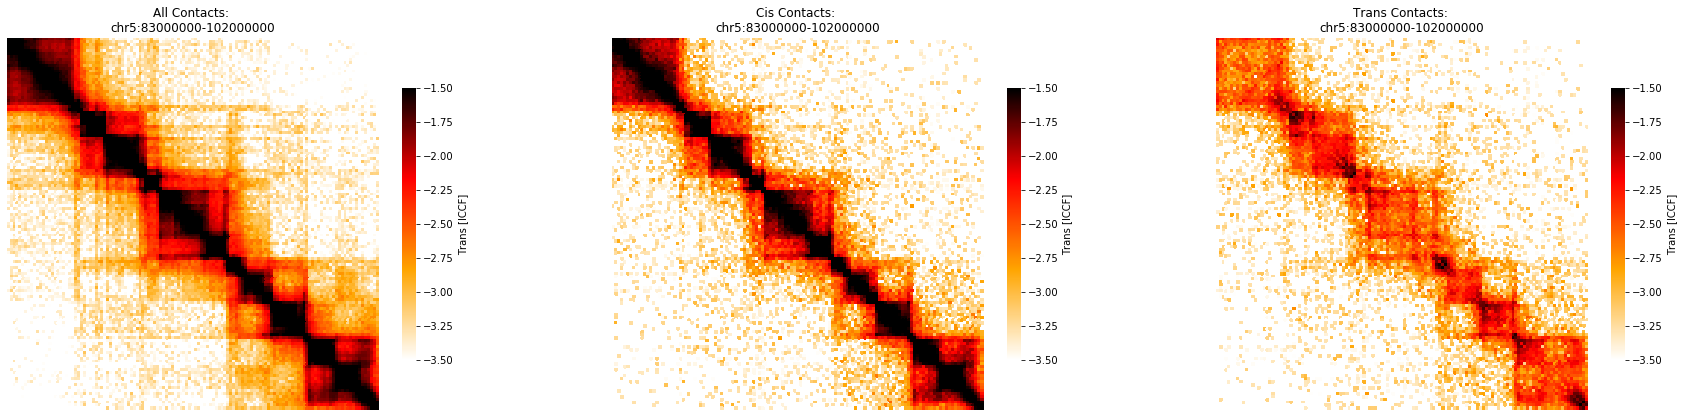

In [69]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

### Write to file

In [27]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr5_examp_1_150kb.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr5_examp_1_150kb.pdf"), bbox_inches="tight")

# Plot example on chromosom 3 (Fig. S7c)

In [36]:
# extract info
BINSIZE = 40000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr5:120000000-130000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

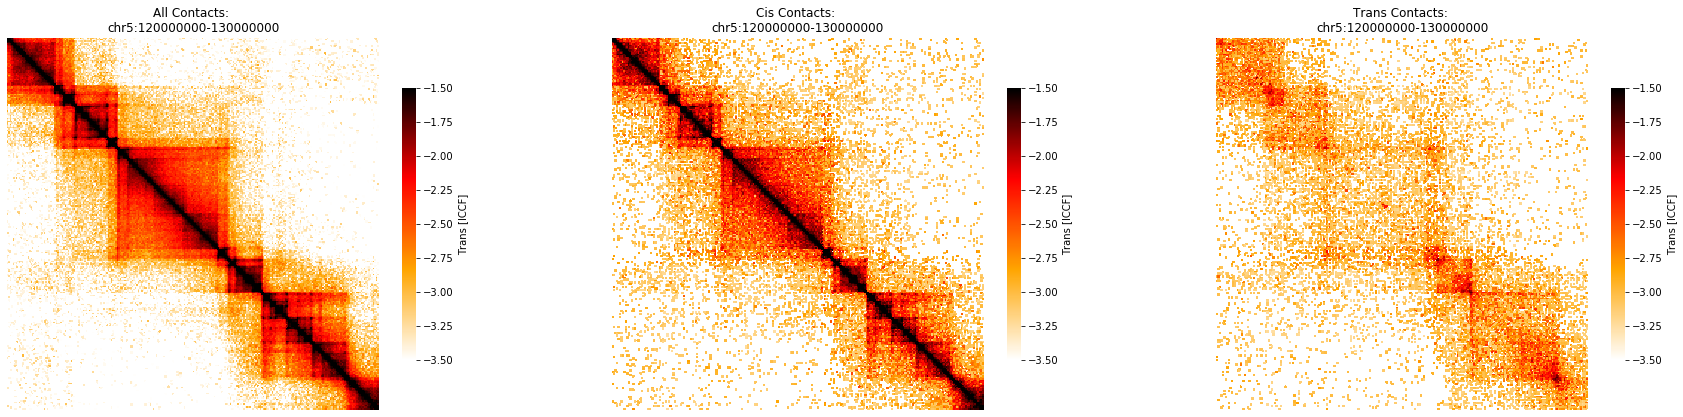

In [37]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## save to file

In [38]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_heatmap.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_heatmap.pdf"), bbox_inches="tight")

## Plot trans contact density

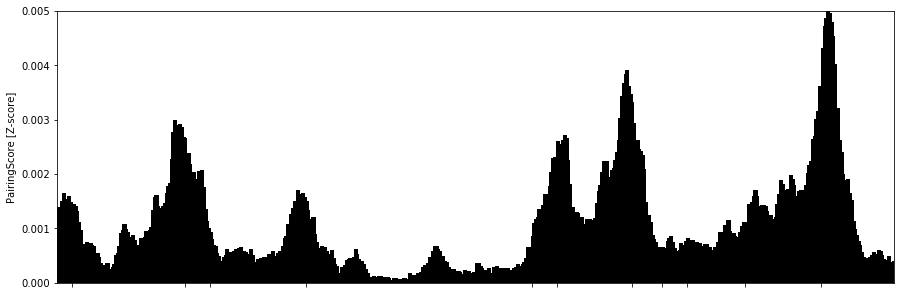

In [39]:
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreTrans
posx = np.linspace(start, end, len(pairingScoreTrans))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore [Z-score]", ylim=(0, 0.005))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## save to file

In [40]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_pairing_score_notNorm_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_pairing_score_norNorm_trans.pdf"), bbox_inches="tight")

## Plot cis contact density

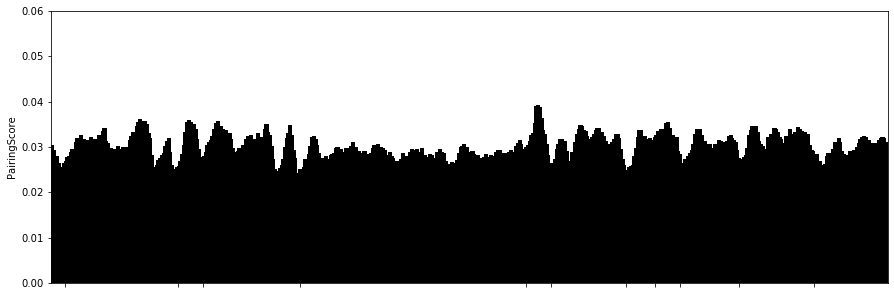

In [41]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreCis = getPairingScore(clrs["cis"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreCis
posx = np.linspace(start, end, len(pairingScoreCis))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.06))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

In [42]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_pairing_score_notNorm_cis.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr5_120-130_40kb_pairing_score_norNorm_cis.pdf"), bbox_inches="tight")

# Plot example 1 on chr.1 (Fig. 4a)

In [23]:
# extract info
BINSIZE = 40000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr1:212000000-222000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

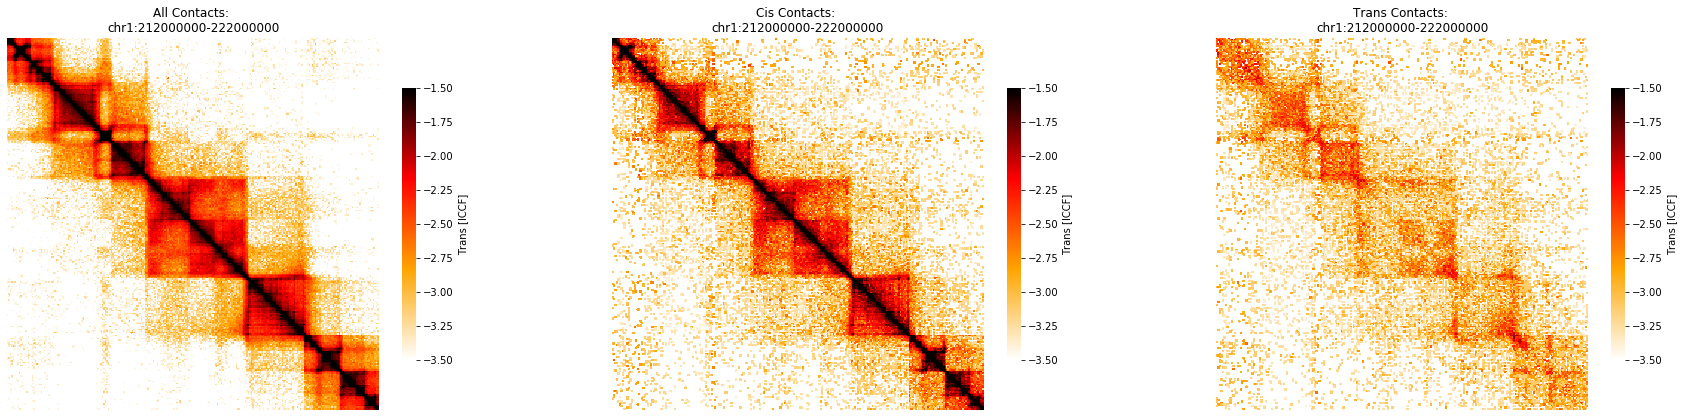

In [24]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

# Plot example on chrom 2 (Fig. 3a)

In [31]:
# extract info
BINSIZE = 40000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr2:55000000-62000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

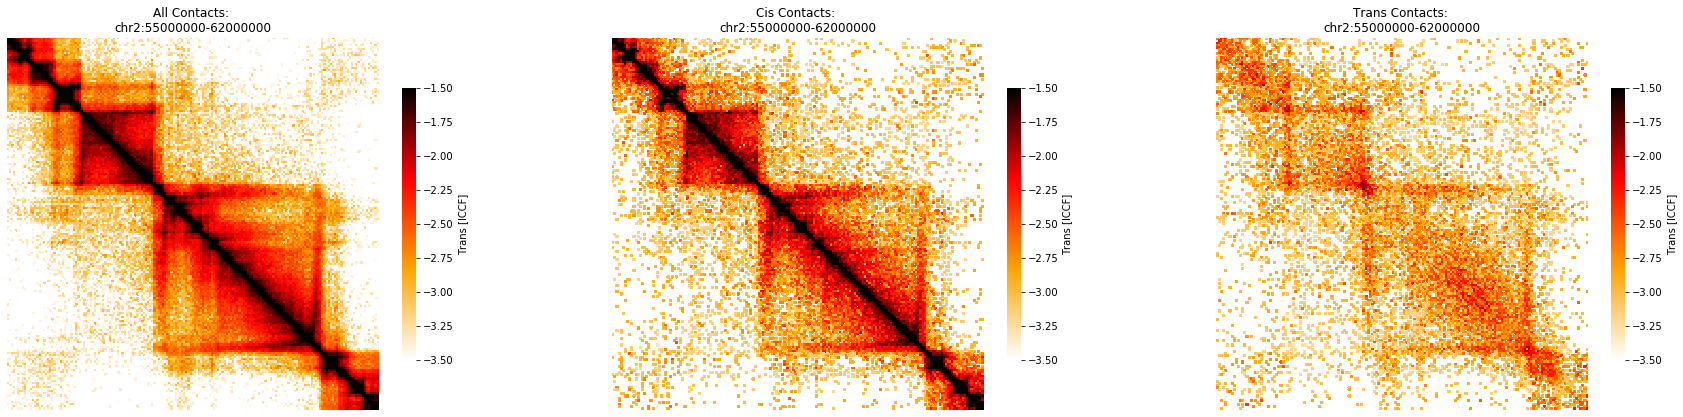

In [32]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## save to file

In [33]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_heatmap.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_heatmap.pdf"), bbox_inches="tight")

## Plot trans contact density

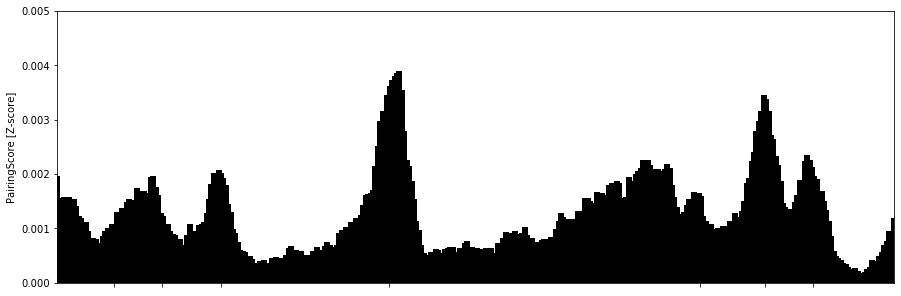

In [10]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreTrans
posx = np.linspace(start, end, len(pairingScoreTrans))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore [Z-score]", ylim=(0, 0.005))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## save to file

In [11]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_pairing_score_notNorm_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_pairing_score_norNorm_trans.pdf"), bbox_inches="tight")

## Plot cis contact density

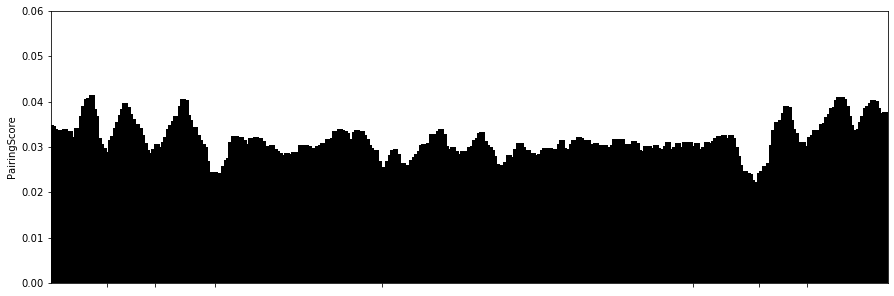

In [12]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreCis = getPairingScore(clrs["cis"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreCis
posx = np.linspace(start, end, len(pairingScoreCis))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.06))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## save to file

In [13]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_pairing_score_notNorm_cis.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr2_examp_1_40kb_pairing_score_norNorm_cis.pdf"), bbox_inches="tight")

# Plot example 2 on chrom 1 (Fig.S7a)

In [29]:
# extract info
BINSIZE = 40000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr1:215000000-223000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

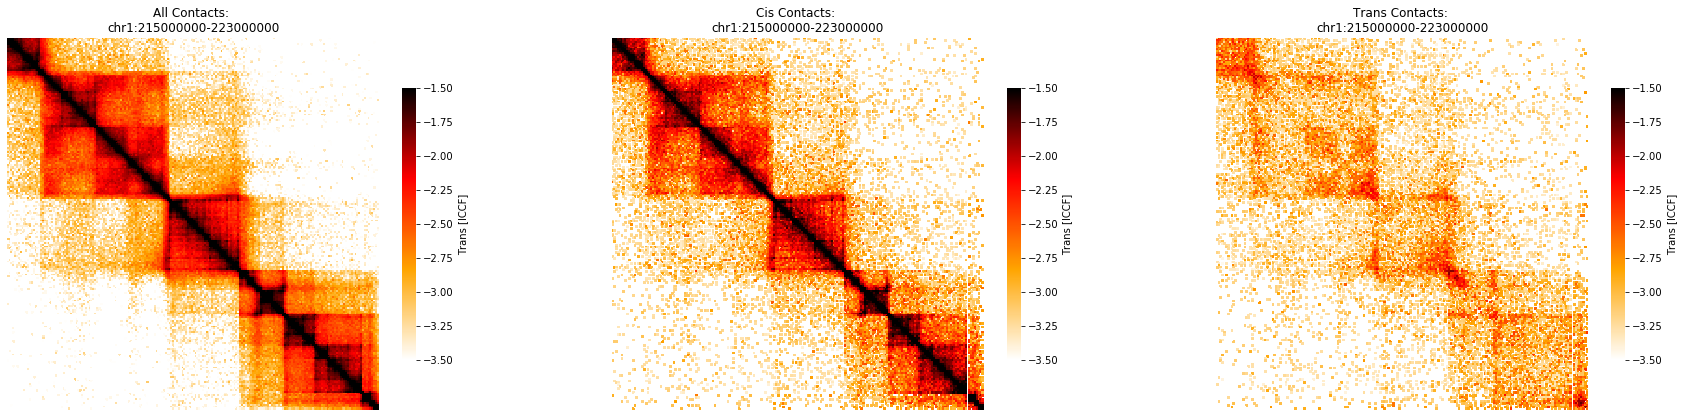

In [30]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## Write to file

In [57]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, f"chrom1_215-223_40kb.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, f"chrom1_215-223_40kb.pdf"), bbox_inches="tight")

## Plot trans contact density

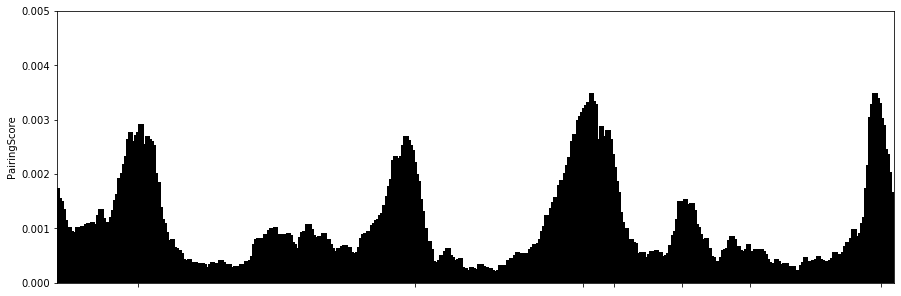

In [32]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreTrans
posx = np.linspace(start, end, len(pairingScoreTrans))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.005))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## Write to file

In [33]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr1_examp_1_40kb_pairing_score_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr1_examp_1_40kb_pairing_score_trans.pdf"), bbox_inches="tight")

## Plot cis contact density

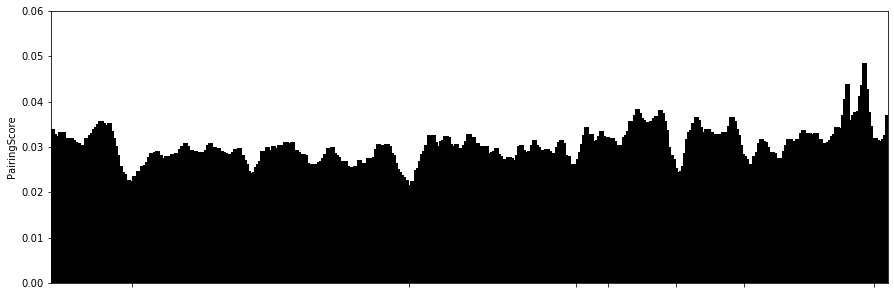

In [34]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreCis = getPairingScore(clrs["cis"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreCis
posx = np.linspace(start, end, len(pairingScoreCis))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.06))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

In [35]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "Chr1_examp_1_40kb_pairing_score_cis.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "Chr1_examp_1_40kb_pairing_score_cis.pdf"), bbox_inches="tight")

# Plot example on chr.3 (Fig.S6b)

In [14]:
# extract info
BINSIZE = 40000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr3:28000000-34000000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

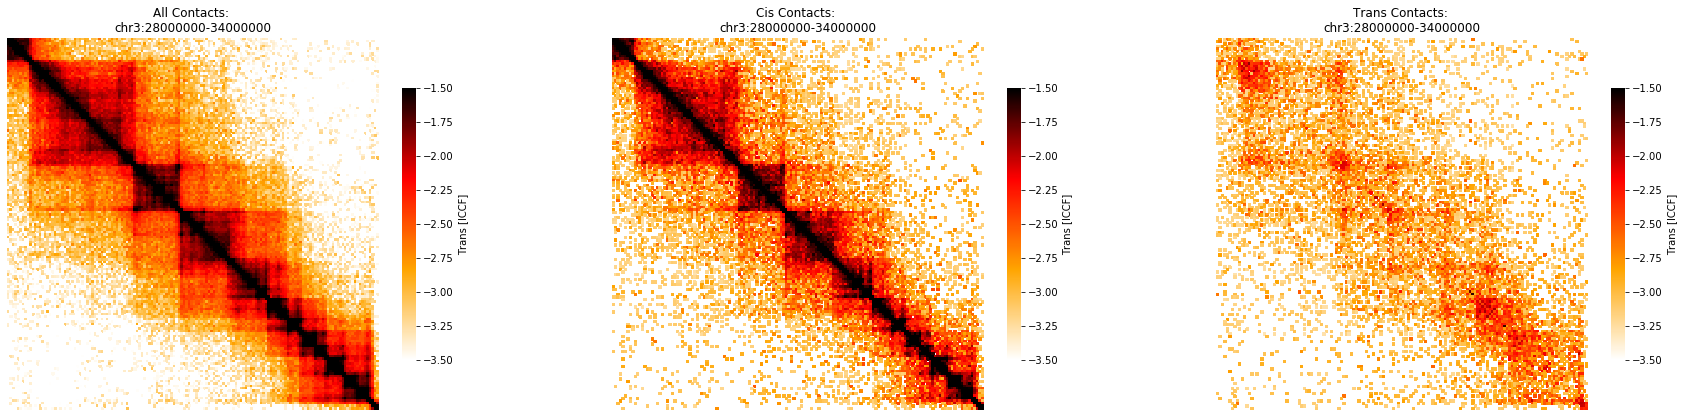

In [15]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

##  save fo file

In [16]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, f"chrom3_28-34_40kb.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, f"chrom1_28-34_40kb.pdf"), bbox_inches="tight")

## Plot trans contact density

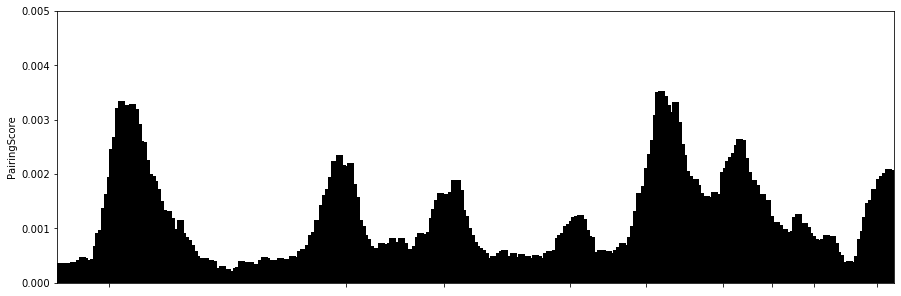

In [17]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreTrans
posx = np.linspace(start, end, len(pairingScoreTrans))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.005))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

##  save to file

In [18]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "chrom3_28-34_40kb_pairing_score_trans.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "chrom3_28-34_40kb_pairing_score_trans.pdf"), bbox_inches="tight")

## Plot cis contact density

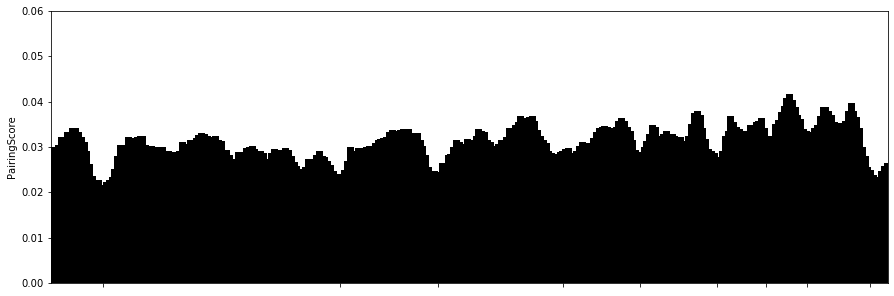

In [19]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreCis = getPairingScore(clrs["cis"], regions=bins, windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreCis
posx = np.linspace(start, end, len(pairingScoreCis))

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="black", width=50000)
ax.set(xlim=(start, end), ylabel="PairingScore", ylim=(0, 0.06))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## save to file

In [20]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "chrom3_28-34_40kb_pairing_score_cis.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "chrom3_28-34_40kb_pairing_score_cis.pdf"), bbox_inches="tight")

# Plot example 2 on chr.3 (Fig.S5a)

In [116]:
# extract info
BINSIZE = 30000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')

# Hollow example 1

coord = "chr3:39000000-42500000"

allExamp = clrs["all"].matrix(balance=True).fetch(coord)
cisExamp = clrs["cis"].matrix(balance=True).fetch(coord)
transExamp = clrs["trans"].matrix(
    balance=True).fetch(coord)

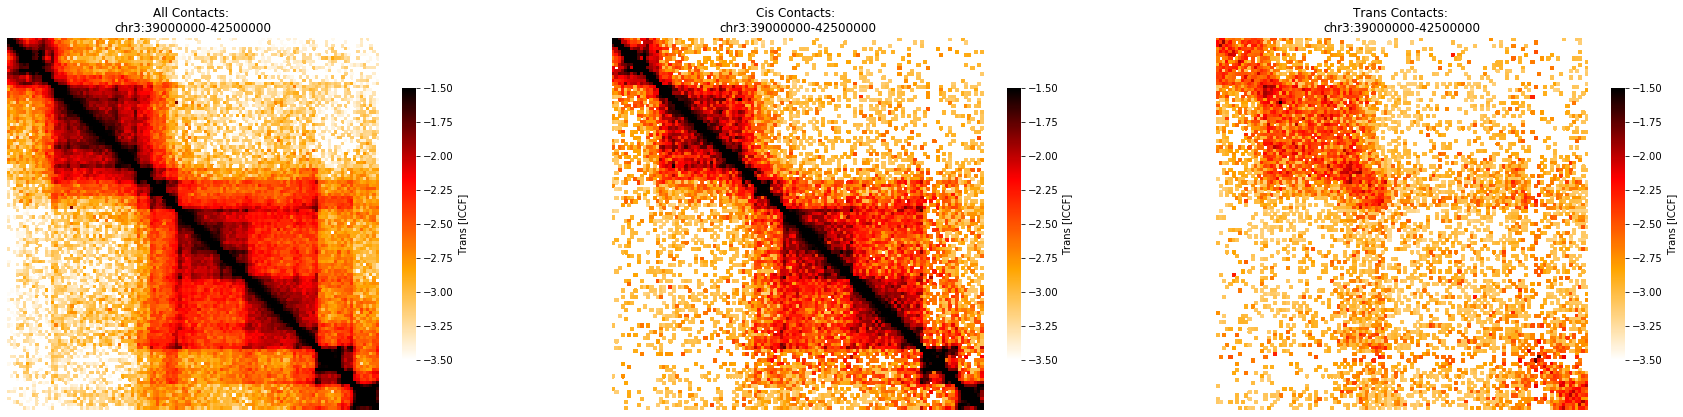

In [117]:
f, ax = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(np.log10(allExamp), cmap=cmapFall, ax=ax[0], vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(cisExamp), cmap=cmapFall, ax=ax[1],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
sbn.heatmap(np.log10(transExamp), cmap=cmapFall, ax=ax[2],  vmin=-3.5, vmax=-1.5,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans [ICCF]"})
ax[0].set_title(f"All Contacts: \n{coord}")
ax[1].set_title(f"Cis Contacts: \n{coord}")
ax[2].set_title(f"Trans Contacts: \n{coord}")
f.set_size_inches(30, 10)
plt.show()

## Save to file

In [118]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_heatmap.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_heatmap.pdf"), bbox_inches="tight")

## Plot ratio of cis/trans

In [106]:
arms = HT.getArmsHg19()
exp = {interType:
       HT.getExpected(clrs[interType], arms, proc=10)
       for interType in ["cis", "trans"]
       }
transSnipper = cooltools.snipping.ObsExpSnipper(clrs["trans"], exp["trans"])
cisSnipper = cooltools.snipping.ObsExpSnipper(clrs["cis"], exp["cis"])

In [107]:
region = pd.DataFrame({"chrom": coord.split(":")[0],
                       "start": int(coord.split(":")[1].split("-")[0]),
                       "end": int(coord.split(":")[1].split("-")[1]),
                       "region": "chr3:0-90900000"}, index=[0])
region

chrom     start       end           region
0  chr3  39000000  42500000  chr3:0-90900000

In [120]:
cisExamp = cooltools.snipping.pileup(region, cisSnipper.select, cisSnipper.snip)
transExamp = cooltools.snipping.pileup(region, transSnipper.select, transSnipper.snip)

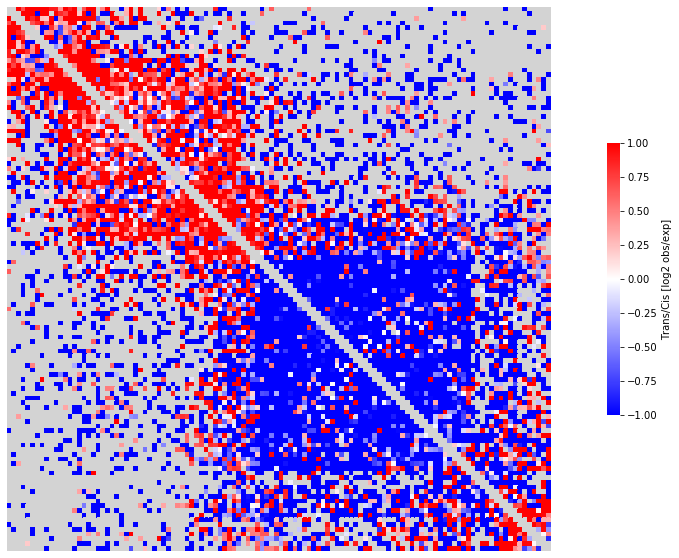

In [121]:
ratio = transExamp[:,:, 0]/cisExamp[:, :, 0]
# add pseudocount
ratio = ratio + 0.01
#calcualte ratio
transOcis = np.log2(ratio)
# define colormap
cmap = plt.cm.bwr
cmap.set_bad("lightgrey")
#plot
f, ax = plt.subplots()
plt.subplots_adjust(wspace=0.3)
sbn.heatmap(transOcis, cmap=cmap, ax=ax, vmin=-1, vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            rasterized=True,
            cbar_kws={"shrink": 0.5, "label": "Trans/Cis [log2 obs/exp]"})
f.set_size_inches(20, 10)
plt.show()

## Save to file

In [122]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_trans_cis_ratio.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_trans_cis_ratio.pdf"), bbox_inches="tight")

## Plot pairing score

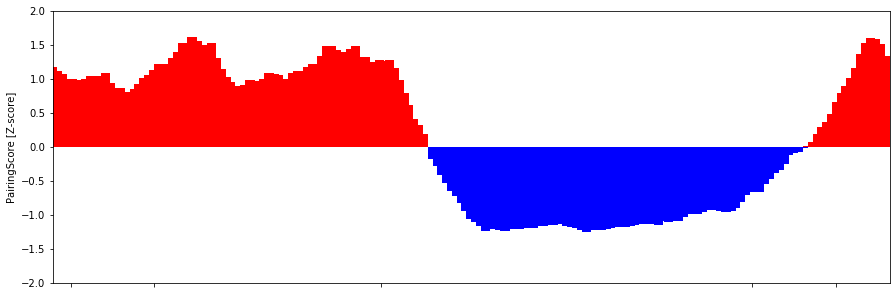

In [111]:
# make dummy cooler for binsize
# extract info
BINSIZE = 20000

clrs = {interType:
        cooler.Cooler(
            f'G2.fc_1_2_3_4.wOldG2.{interType}.1000.mcool::/resolutions/{BINSIZE}')
        for interType in ["cis", "trans"]
        }
clrs["all"] = cooler.Cooler(
            f'../../Pooled_FC_1_2/cooler/G2.fc_1_2.all.1000.mcool::/resolutions/{BINSIZE}')
# get bins for pairing score
bins = clrs["trans"].matrix(balance=True,  join=True, as_pixels=True).fetch(coord).iloc[:, [0, 1, 2]].drop_duplicates().rename(columns={"chrom1": "chrom", "start1": "start", "end1": "end"})
# calculate middle
bins.loc[:, "mid"] = (bins["start"] + bins["end"])//2
# calculate pairing score
pairingScoreTrans = getPairingScore(clrs["trans"], regions=bins, windowsize=20*10**4, norm=False, blankDiag=True)["PairingScore"]
# normalize 
pairingScoreTrans = (pairingScoreTrans - np.nanmedian(genomeWidePairingScore))/np.nanstd(genomeWidePairingScore)
# Plot
chrom = coord.split(":")[0]
start = int(coord.split(":")[1].split("-")[0])
end = int(coord.split(":")[1].split("-")[1])


pos = pairingScoreTrans[pairingScoreTrans > 0]
posx = np.linspace(start, end, len(pairingScoreTrans))[pairingScoreTrans > 0]
neg = pairingScoreTrans[pairingScoreTrans < 0]
negx = np.linspace(start, end, len(pairingScoreTrans))[pairingScoreTrans < 0]

# get TAD locations

TADboundaries = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)

relevantBoundaries = TADboundaries.loc[(TADboundaries[0] == chrom) &
                                       (TADboundaries[1] > start) &
                                       (TADboundaries[2] < end)]

# calculate boundaries

boundLeft = relevantBoundaries[[0, 1]]
boundLeft.columns = ["chrom", "mid"]
boundRight = relevantBoundaries[[0, 2]]
boundRight.columns = ["chrom", "mid"]
boundaries = pd.concat((boundLeft, boundRight)).drop_duplicates()


f, ax = plt.subplots()
ax.bar(posx, pos, color="red", width=40000)
ax.bar(negx, neg, color="blue", width=40000)
ax.set(xlim=(start, end), ylabel="PairingScore [Z-score]", ylim=(-2, 2))
plt.xticks(boundaries["mid"])
ax.set_xticklabels("")
f.set_size_inches(15, 5)

## Save to file

In [112]:
resultdir = "/groups/gerlich/experiments/Experiments_004800/004812/Results/FC_1_2_3_4/Examples"
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_pairing_score_norm.png"), bbox_inches="tight")
f.savefig(os.path.join(resultdir, "chrom3_39-42.5_40kb_pairing_score_norm.pdf"), bbox_inches="tight")